In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
x = np.array([0,10, 33, 100, 333, 1000])
y = np.array([15, 16, 16, 27, 33, 20, 21, 18, 26, 41, 38, 27, 29, 21, 33, 60, 41, 42]).reshape(6,3, order='F')

In [47]:
y*np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]).reshape(6,3, order='F')

array([[ 15, 147, 377],
       [ 32, 144, 294],
       [ 48, 234, 495],
       [108, 410, 960],
       [165, 418, 697],
       [120, 324, 756]])

In [212]:
def gibbs(x, y, nchain, init_abgt, sd_prop):
    chain_alpha = np.zeros((nchain+1, 1))
    chain_alpha[0] = init_abgt[0]
    chain_beta = np.zeros((nchain+1, 1))
    chain_beta[0] = init_abgt[1]
    chain_gamma = np.zeros((nchain+1,1))
    chain_gamma[0] = init_abgt[2]
    chain_tau = np.zeros((nchain+1,1))
    chain_tau[0] = init_abgt[3]
    
    mu_candidate = np.zeros((6,3))
    mu = np.zeros((6,3))
    
    acc_alpha = 0
    acc_beta = 0
    acc_gamma = 0
    
    # Hyperparamètres 
    a = 1/1000
    b = 1/1000
    sigma = 100000
    
    for i in range(nchain):
        # MAJ tau
        # Lambda
        l = np.random.normal(0, 1/chain_tau[i], size=6*3).reshape(6,3)
        # tau
        chain_tau[i+1] = np.random.gamma(a + (1/2)*3*6, 1/(b) + (1/2*((l**2)).sum()))
        
        # Utile pour la MAJ de alpha beta et gamma
        l = np.random.normal(0, 1/chain_tau[i+1], size=6*3).reshape(6,3)
        
        # MAJ alpha par MH
        alpha_candidate = np.random.normal(chain_alpha[i], sd_prop[0])
        for I in range (6):
            for J in range(3):
                mu_candidate[I,J] = np.exp(np.clip(alpha_candidate + chain_beta[i,0]*np.log(x[I]+10) + chain_gamma[i,0]*x[I] + l[I,J],a_min = None, a_max = 700))
                mu[I,J] = np.exp(np.clip(chain_alpha[i,0] + chain_beta[i,0]*np.log(x[I]+10) + chain_gamma[i,0]*x[I] + l[I,J],a_min = None, a_max = 700))
        
        top = (alpha_candidate**2)/(2*sigma**2) + (mu_candidate- y*np.log(mu_candidate)).sum()
        bottom = (chain_alpha[i]**2)/(2*sigma**2) + (mu - y*np.log(mu)).sum()
        ratio = top - bottom
        
        u = np.log(np.random.uniform())
        
        if (u < ratio):
            chain_alpha[i+1] = alpha_candidate
            acc_alpha +=1
        else : 
            chain_alpha[i+1] = chain_alpha[i]
            
            
        # MAJ beta par MH 
        beta_candidate = np.random.normal(chain_beta[i], sd_prop[1])
        for I in range(6):
            for J in range(3):
                mu_candidate[I,J] = np.exp(np.clip(chain_alpha[i+1,0] + beta_candidate*np.log(x[I]+10) + chain_gamma[i,0]*x[I] + l[I,J],a_min = None, a_max = 700))
                mu[I,J] = np.exp(np.clip(chain_alpha[i+1,0] + chain_beta[i,0]*np.log(x[I]+10) + chain_gamma[i,0]*x[I] + l[I,J],a_min = None, a_max = 700))
                
        top = (beta_candidate**2)/(2*sigma**2) + (mu_candidate - y*np.log(mu_candidate)).sum()
        bottom = (chain_beta[i]**2)/(2*sigma**2) + (mu - y*np.log(mu)).sum()
        ratio = top-bottom
        
        u = np.log(np.random.uniform())
        
        if (u < ratio):
            chain_beta[i+1] = beta_candidate
            acc_beta +=1
        else:
            chain_beta[i+1] = chain_beta[i]
        
        # MAJ gamma par MH 
        gamma_candidate = np.random.normal(chain_gamma[i], sd_prop[2])
        for I in range(6):
            for J in range(3):
                mu_candidate[I,J] = np.exp(np.clip(chain_alpha[i+1,0] + chain_beta[i+1,0]*np.log(x[I]+10) + gamma_candidate*x[I] + l[I,J],a_min = None, a_max = 700))
                mu[I,J] = np.exp(np.clip(chain_alpha[i+1,0] + chain_beta[i+1,0]*np.log(x[I]+10) + chain_gamma[i,0]*x[I] + l[I,J],a_min = None, a_max = 700))
                
        top = (gamma_candidate**2)/(2*sigma**2) + (mu_candidate - y*np.log(mu_candidate)).sum()
        bottom = (chain_gamma[i]**2)/(2*sigma**2) + (mu - y*np.log(mu)).sum()
        ratio = top-bottom
        
        u = np.log(np.random.uniform())
        
        if (u < ratio):
            chain_gamma[i+1] = gamma_candidate
            acc_gamma +=1
        else:
            chain_gamma[i+1] = chain_gamma[i]
        
        
        
        
    return(chain_tau, chain_alpha, chain_beta, chain_gamma, np.array([acc_alpha, acc_beta, acc_gamma])/(nchain))

In [213]:
tau, alpha, beta, gamma, acc_proba = gibbs(x,y,10000,np.array([0.5,0.5,0.5,1]),np.array([0.03,0.1,0.02]))

/var/folders/44/m2grdsw162ld66b4rw5qzxdr0000gn/T/ipykernel_23313/2792620426.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_candidate[I,J] = np.exp(np.clip(alpha_candidate + chain_beta[i,0]*np.log(x[I]+10) + chain_gamma[i,0]*x[I] + l[I,J],a_min = None, a_max = 700))
/var/folders/44/m2grdsw162ld66b4rw5qzxdr0000gn/T/ipykernel_23313/2792620426.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_candidate[I,J] = np.exp(np.clip(chain_alpha[i+1,0] + beta_candidate*np.log(x[I]+10) + chain_gamma[i,0]*x[I] + l[I,J],a_min = None, a_max = 700))
/var/folders/44/m2grdsw162ld66b4rw5qzxdr0000gn/T/ipykernel_23313/2792620426.py:76: Deprecation

In [214]:
acc_proba

array([0.9983, 0.9981, 0.9931])

In [215]:
vector_lag = np.arange(0,(10000-1000),5)

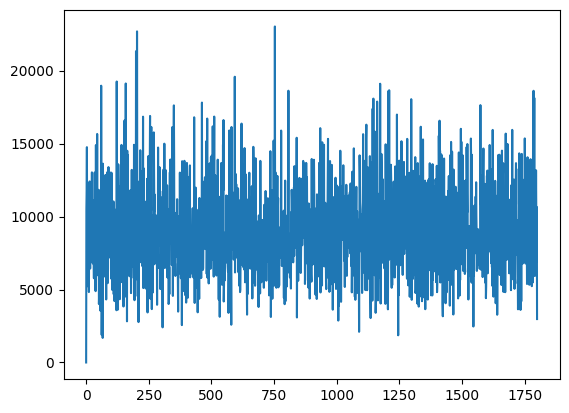

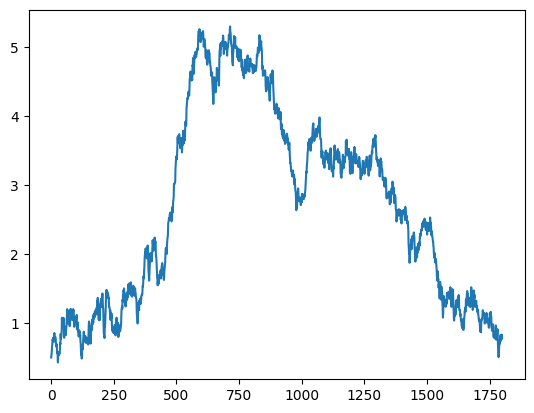

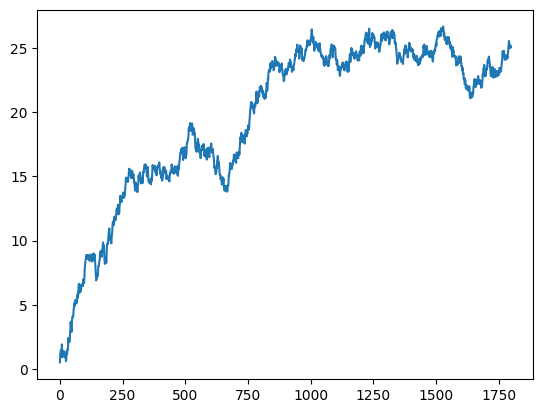

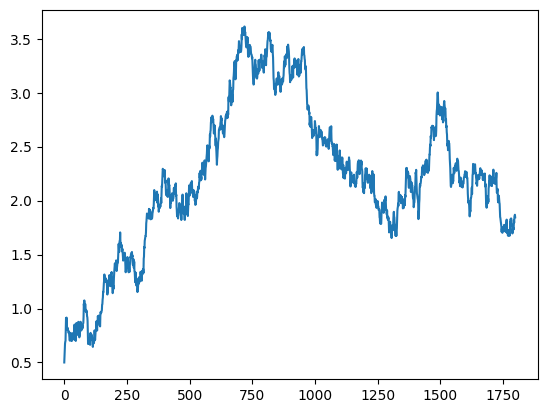

In [216]:
plt.plot(tau[vector_lag])
plt.show()
plt.plot(alpha[vector_lag])
plt.show()
plt.plot(beta[vector_lag])
plt.show()
plt.plot(gamma[vector_lag])
plt.show()